In [1]:
import numpy as np
import gym

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, merge, LSTM, Reshape
from keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess


ENV_NAME = 'Pendulum-v0'
gym.undo_logger_setup()


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

Using TensorFlow backend.


In [4]:
# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Reshape((1, 16)))
actor.add(LSTM(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = merge([action_input, flattened_observation], mode='concat')
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Reshape((1, 32))(x)
x = LSTM(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(input=[action_input, observation_input], output=x)

memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

histL = agent.fit(env, nb_steps=50000, visualize=False, verbose=0, nb_max_episode_steps=200)

# ~10 min.

In [6]:
# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = merge([action_input, flattened_observation], mode='concat')
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(input=[action_input, observation_input], output=x)

memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

history = agent.fit(env, nb_steps=40000, visualize=False, verbose=0, nb_max_episode_steps=200)

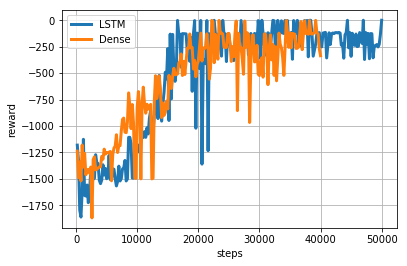

In [7]:
from matplotlib import pyplot
%matplotlib inline

pyplot.plot(histL.history['nb_steps'], histL.history['episode_reward'], linewidth=3, label='LSTM')
pyplot.plot(history.history['nb_steps'], history.history['episode_reward'], linewidth=3, label='Dense')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('steps')
pyplot.ylabel('reward')
#pyplot.yscale('log')
pyplot.show()

In [ ]:
# 微妙？
# LSTMのほうが立ち上がり遅いが非線形に加速？
# もっと記憶を必要とするタスクでないと？